In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**Importing County, and COVID-19 Data**

**as of (04/16/2020)**

**Note**: see the `data_collection_preprocessing.ipynb` notebook for more info about these datasets. In a nutshell, COVID-19 dataset contains the daily cumulative counts of cases and deaths for US counties (NY Times). The county dataset contains data (county-level) about demographic, health, poverty, and food insecurity factors along with the number of COVID-19 cases and deaths.

In [2]:
counties = pd.read_csv('county_data.csv', dtype={'FIPS': object})
covid = pd.read_csv('covid_daily.csv', dtype={'FIPS': object})

In [3]:
# remove unwanted strings from food insecurity rate column 'insecure_perc'
counties['insecure_perc'] = counties['insecure_perc'].map(lambda x: x.rstrip('%'))
# convert two columns to be numeric
counties['poverty_per'] = pd.to_numeric(counties.poverty_per, errors='coerce')
counties['insecure_perc'] = pd.to_numeric(counties.insecure_perc)
counties.head()

County   FIPS         lapop1       lalowi1    laseniors1       lawhite1  \
0  Autauga  01001   36469.872896  12899.819468   4245.641526   28592.192360   
1  Baldwin  01003  131649.158743  44343.516539  21633.863020  114569.054528   
2  Barbour  01005   19197.262382   9721.108548   2560.043174    9924.136304   
3     Bibb  01007   18918.377818   8937.631914   2286.891978   14775.827537   
4   Blount  01009   52242.222279  20568.194560   7301.222109   48763.477094   

       lablack1      lahunv1      lapop10     lalowi10   ...    WA_FEMALE  \
0   6645.162299   677.672769  7027.788425  2895.995078   ...      21801.0   
1  10709.565455  1394.162766  2913.544414  1135.997370   ...      97830.0   
2   8196.688099   425.144927  5501.798819  2732.660958   ...       5799.0   
3   3775.872255   224.388125   295.614426   164.903295   ...       8449.0   
4    552.119031   719.931444  1955.518792   896.301342   ...      28149.0   

   BA_MALE  BA_FEMALE  white_per  black_per  nonwhite_per   county    state  \
0   5153.0     5762.0  76.725239  19.630942     23.274761  Autauga  Alabama   
1   9400.0    10092.0  87.285228   8.940382     12.714772  Baldwin  Alabama   
2   6370.0     5672.0  49.069571  48.398376     50.930429  Barbour  Alabama   
3   2954.0     1816.0  76.834821  21.294643     23.165179     Bibb  Alabama   
4    507.0      443.0  95.878285   1.642462      4.121715   Blount  Alabama   

   cases  deaths  
0   25.0     2.0  
1  102.0     2.0  
2   14.0     0.0  
3   24.0     0.0  
4   18.0     0.0  

[5 rows x 40 columns]

In [4]:
# make food access features percentages instead of crude counts
food_access_vars = ['lapop1', 'lalowi1', 'laseniors1', 'lawhite1', 'lablack1', 'lahunv1', 'lapop10', 'lalowi10', 'laseniors10', 'lawhite10', 'lablack10', 'lahunv10']
counties[food_access_vars] = counties[food_access_vars].apply(lambda x: (x/counties['TOT_POP'])*100)

In [5]:
covid.head()

date     county       state   FIPS  cases  deaths
0  2020-01-21  Snohomish  Washington  53061      1       0
1  2020-01-22  Snohomish  Washington  53061      1       0
2  2020-01-23  Snohomish  Washington  53061      1       0
3  2020-01-24       Cook    Illinois  17031      1       0
4  2020-01-24  Snohomish  Washington  53061      1       0

## The Big Picture

**The total number of cases and number of new cases over time for the entire country**

In [6]:
# total cases per day
daily_cases = covid.groupby(['date'])['cases'].sum().reset_index()
# adding daily new cases column
daily_cases['new_cases'] = daily_cases['cases'].sub(daily_cases['cases'].shift())
# adding day numbers
daily_cases['day'] = np.arange(1, len(daily_cases)+1)
# display the last 10 days
daily_cases.tail(10)

date   cases  new_cases  day
77  2020-04-07  397752    31390.0   78
78  2020-04-08  429283    31531.0   79
79  2020-04-09  463689    34406.0   80
80  2020-04-10  496904    33215.0   81
81  2020-04-11  528412    31508.0   82
82  2020-04-12  555328    26916.0   83
83  2020-04-13  580892    25564.0   84
84  2020-04-14  607264    26372.0   85
85  2020-04-15  636875    29611.0   86
86  2020-04-16  668542    31667.0   87

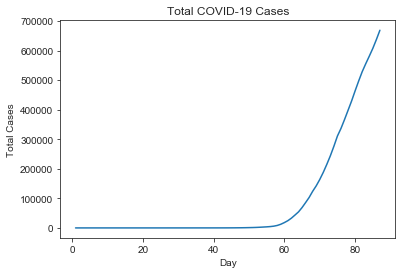

In [7]:
sb.set_style("ticks")
sb.lineplot(data = daily_cases, x = daily_cases['day'], y = daily_cases['cases']);
plt.title('Total COVID-19 Cases');
plt.xlabel('Day');
plt.ylabel('Total Cases');

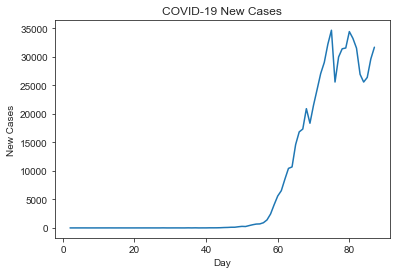

In [8]:
sb.set_style("ticks")
sb.lineplot(data = daily_cases, x = daily_cases['day'], y = daily_cases['new_cases']);
plt.title('COVID-19 New Cases');
plt.xlabel('Day');
plt.ylabel('New Cases');

Looking at the total cases plot alone, it's hard to tell at what stage we are regarding exponential growth in number of cases. The chart for daily new cases may suggest the situation is starting to get under control.

**New Cases vs. Existing Cases**

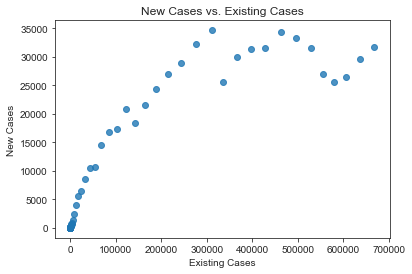

In [9]:
sb.regplot(data = daily_cases, x = daily_cases['cases'], y = daily_cases['new_cases'], fit_reg=False);
plt.title('New Cases vs. Existing Cases');
plt.xlabel('Existing Cases');
plt.ylabel('New Cases');

Another sign that things are getting under control. The number of new cases per day has peaked at the point where total number of cases was approx. 300,000.

## County-level Analysis

**Summary stats for the number of cases and deaths**

In [10]:
# getting summary stats
counties[['cases', 'deaths']].describe()

cases       deaths
count    2706.000000  2706.000000
mean      244.607169    11.247228
std      2637.486012   173.729958
min         0.000000     0.000000
25%         4.000000     0.000000
50%        14.000000     0.000000
75%        57.000000     2.000000
max    123146.000000  8632.000000

In [11]:
counties[counties['FIPS']=='36061'][['county', 'cases', 'deaths']]

county     cases  deaths
1858  New York City  123146.0  8632.0

The maximum number of cases for a county is 123,146 (New York County). However, 75% of the counties have 57 cases or fewer. 
The maximum number of deaths for a county is 8,632 (New York County). However, 75% of the counties have 2 deaths or fewer.
It's obvious that NYC has distorted the distribution significantly.

**Summary stats for food insecurity, poverty, and some demographic variables**

In [12]:
counties[['insecure_perc', 'pop_den_permile', 'poverty_per', 'white_per', 'black_per']].describe()

insecure_perc  pop_den_permile  poverty_per    white_per    black_per
count    3143.000000      3127.000000  3142.000000  3143.000000  3143.000000
mean       13.251639       256.434890    15.163304    84.458555     9.338106
std         3.959942      1719.713783     6.124835    16.394723    14.472795
min         2.900000         0.000000     2.600000     3.841985     0.000000
25%        10.600000        17.000000    10.800000    79.581916     0.867400
50%        12.800000        45.200000    14.100000    91.392664     2.543449
75%        15.200000       113.500000    18.300000    95.521506    10.855604
max        36.300000     69468.400000    54.000000    99.043785    86.069762

**Variables are (respectively)**: food insecurity rate, population density, % of population below poverty level, % of white population, % of black population.

**Summary stats for some health variables**

In [13]:
counties['old_perc'] = counties['old_perc']*100
counties[['diab_perc', 'hyper_perc', 'old_perc', 'CRUDE_RATE', 'CRD_MR']].describe()

diab_perc   hyper_perc     old_perc   CRUDE_RATE       CRD_MR
count  3127.000000  3127.000000  3127.000000  2935.000000  3127.000000
mean     10.376335    39.407944    13.129517   579.232572    63.816719
std       3.800037     3.654913     3.477859   130.647236    16.881251
min       1.500000    27.900000     3.000000    -1.000000    14.270000
25%       7.800000    37.055000    11.000000   503.000000    52.180000
50%       9.900000    38.770000    13.000000   588.000000    62.400000
75%      12.500000    41.165000    15.000000   658.500000    73.380000
max      33.000000    56.230000    42.000000  1361.000000   160.970000

**Variables are (respectively)**: % of diabetic population, % of population with Hypertension, % of senior people, crude rate for cancer, crude rate for Chronic Respiratory Diseases

## Correlations

**Caveat**: Pearson Correlation Coefficient detects **linear** relationships, while Spearman's Rank Correlation Coefficient could be useful as a measure of **non-linear** relationships.

**COVID-19 metrics with food access features**

**Pearson correlation coefficient**

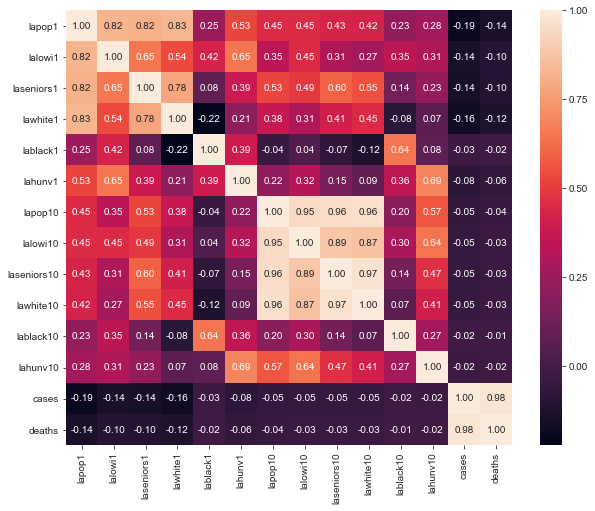

In [14]:
food_access_vars.extend(['cases', 'deaths'])
# correlation matrix
plt.figure(figsize = [10, 8]);
sb.heatmap(counties[food_access_vars].corr(), annot=True, fmt='0.2f');

**Spearman's rank correlation coefficient**

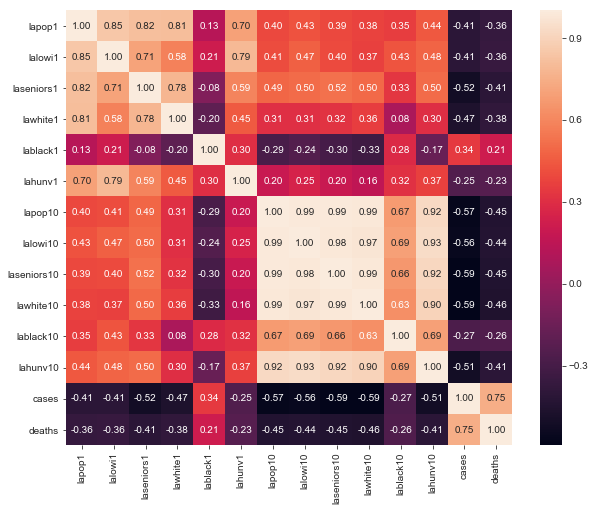

In [15]:
# correlation matrix
plt.figure(figsize = [10, 8]);
sb.heatmap(counties[food_access_vars].corr(method='spearman'), annot=True, fmt='0.2f');

**COVID-19 metrics with demographics**

**Pearson correlation coefficient**

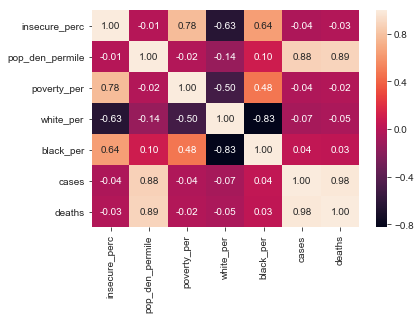

In [16]:
# correlation matrix
sb.heatmap(counties[['insecure_perc', 'pop_den_permile', 'poverty_per',
                     'white_per', 'black_per', 'cases', 'deaths']].corr(), annot=True, fmt='0.2f');

**Spearman's rank correlation coefficient**

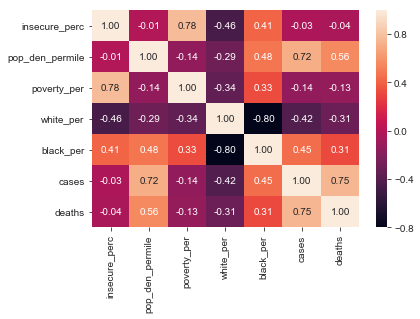

In [17]:
# correlation matrix
sb.heatmap(counties[['insecure_perc', 'pop_den_permile', 'poverty_per',
                     'white_per', 'black_per', 'cases', 'deaths']].corr(method='spearman'), annot=True, fmt='0.2f');

Correlations between black counties and COVID-19 metrics are stronger when using Spearman's coefficient

**COVID-19 metrics with health factors**

**Pearson correlation coefficient**

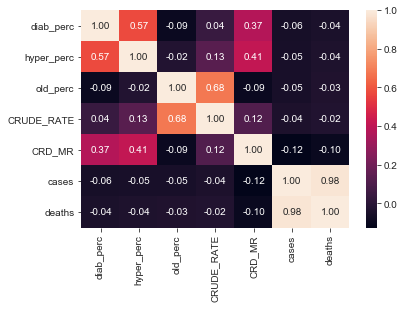

In [18]:
# correlation matrix
sb.heatmap(counties[['diab_perc', 'hyper_perc', 'old_perc', 'CRUDE_RATE', 'CRD_MR',
                     'cases', 'deaths']].corr(), annot=True, fmt='0.2f');

**Spearman's rank correlation coefficient**

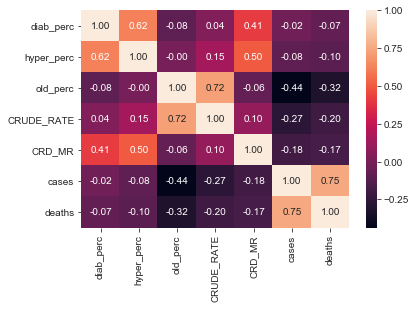

In [19]:
# correlation matrix
sb.heatmap(counties[['diab_perc', 'hyper_perc', 'old_perc', 'CRUDE_RATE', 'CRD_MR',
                     'cases', 'deaths']].corr(method='spearman'), annot=True, fmt='0.2f');

## Black Counties
**Excluding New York County**

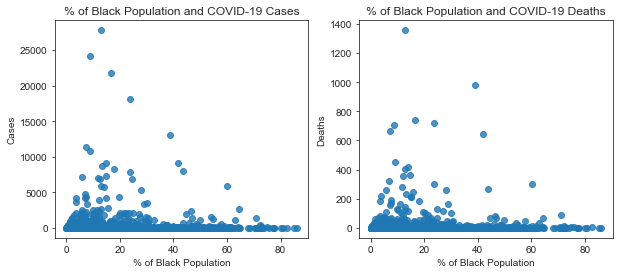

In [35]:
# excluding New York since it's an outlier
exc_ny = counties[counties['FIPS'] != '36061']

plt.figure(figsize = [10, 4]);
#####
plt.subplot(1, 2, 1)
sb.regplot(data = exc_ny, x = exc_ny['black_per'], y = exc_ny['cases'], fit_reg=False);
plt.title('% of Black Population and COVID-19 Cases');
plt.xlabel('% of Black Population');
plt.ylabel('Cases');

plt.subplot(1, 2, 2)
sb.regplot(data = exc_ny, x = exc_ny['black_per'], y = exc_ny['deaths'], fit_reg=False);
plt.title('% of Black Population and COVID-19 Deaths');
plt.xlabel('% of Black Population');
plt.ylabel('Deaths');

More rigorous Hypothesis Testing is needed before any conclusions are made about the relationship between black people and COVID-19 metrics

## Growth of COVID-19 Cases per County

#### Create a Dataframe: rows = counties, columns = dates

The reason this dataframe is created this way is to show the progression of the number of cases per county over time.

In [21]:
# keeping most recent cases and deaths counts
most_recent = covid[covid['date']=='2020-04-16']
# unique county fips
FIPS = list(set(most_recent['FIPS']))
dates = list(set(covid['date']))
dates.sort()

#### Create a zero Dataframe called: `cases`

In [22]:
cases = pd.DataFrame(0, columns=dates, index=FIPS)

#### Populate the `cases` Dataframe from COVID-19 Daily Cases Data

In [23]:
# loop through dates
for date in dates:
    # loop through covid dataframe
    for index, row in covid[covid['date'] == date].iterrows():
        try:
            cases.loc[row['FIPS']][date] = row['cases']
        # if a county doesn't exist in cases df, add it then add its number of cases
        except KeyError:
            cases.loc[row['FIPS']] = 0
            cases.loc[row['FIPS']][date] = row['cases']

# since some counties' FIPS are missing, the 'cases' dataframe
# will have a row labeled 'NaN'. 
# drop the 'NaN' row
cases.drop([np.NaN], axis=0, inplace=True)
cases.head()

2020-01-21  2020-01-22  2020-01-23  2020-01-24  2020-01-25  2020-01-26  \
40043           0           0           0           0           0           0   
48111           0           0           0           0           0           0   
28111           0           0           0           0           0           0   
36031           0           0           0           0           0           0   
48499           0           0           0           0           0           0   

       2020-01-27  2020-01-28  2020-01-29  2020-01-30     ...      2020-04-07  \
40043           0           0           0           0     ...               1   
48111           0           0           0           0     ...               1   
28111           0           0           0           0     ...              14   
36031           0           0           0           0     ...               7   
48499           0           0           0           0     ...               4   

       2020-04-08  2020-04-09  2020-04-10  2020-04-11  2020-04-12  2020-04-13  \
40043           1           1           1           1           1           1   
48111           1           1           1           1           1           1   
28111          14          14          15          16          18          19   
36031           7           8          10          12          12          12   
48499           4           4           5           5           5           5   

       2020-04-14  2020-04-15  2020-04-16  
40043           1           2           2  
48111           2           2           2  
28111          20          20          20  
36031          12          12          12  
48499           6           6           6  

[5 rows x 87 columns]

In [24]:
cases_transposed = cases.transpose()

**Plotting cumulative number of cases over the last 30 days for ALL counties**

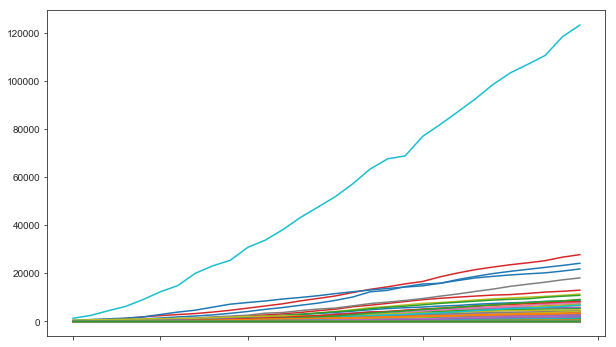

In [25]:
sb.set_style("ticks")
#plt.figure(figsize = [20, 10]);
cases_transposed.iloc[-30:].plot(figsize = [10, 6],legend=False);

## Mapping

In [26]:
# path to the county shapefile
path = 'C:\\Users\\Osama\\Desktop\\OneDrive\\Documents\\Research\\Foodbank\\Data\\tl_2018_us_county\\tl_2018_us_county.shp'
# importing the county shape file
map_df = gpd.read_file(path)
# rename the GEOID column to be FIPS
map_df.rename(columns={'GEOID': 'FIPS'}, inplace=True)
# dropping unnecessary columns
map_df.drop(['COUNTYNS', 'NAME', 'LSAD', 'CLASSFP', 'MTFCC',
             'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
             'AWATER', 'INTPTLAT', 'INTPTLON'], axis=1, inplace=True)
map_df.head()

STATEFP COUNTYFP   FIPS          NAMELSAD  \
0      31      039  31039     Cuming County   
1      53      069  53069  Wahkiakum County   
2      35      011  35011    De Baca County   
3      31      109  31109  Lancaster County   
4      31      129  31129   Nuckolls County   

                                            geometry  
0  POLYGON ((-97.019516 42.004097, -97.019519 42....  
1  POLYGON ((-123.436394 46.238197, -123.447592 4...  
2  POLYGON ((-104.567387 33.997566, -104.567717 3...  
3  POLYGON ((-96.91075099999999 40.784944, -96.91...  
4  POLYGON ((-98.27366699999999 40.089399, -98.27...

**Combining the shapefile with county data**

In [27]:
# with counties data
merged = pd.merge(map_df, counties, left_on='FIPS', right_on='FIPS')
merged.shape

(3143, 44)

In [28]:
# with cases df, which was derived from the raw NY Times data
merged2 = pd.merge(map_df, cases, left_on='FIPS', right_on=cases.index)
merged2.shape

(2723, 92)

In [29]:
# change map projection
merged['geometry'] = merged['geometry'].to_crs(epsg=3857)
merged2['geometry'] = merged2['geometry'].to_crs(epsg=3857)

**Excluding Alaska and Hawaii for Visualization Purposes**

In [30]:
# removing Hawaii
merged = merged[merged['STATEFP']!='15']
merged2 = merged2[merged2['STATEFP']!='15']
# removing Alaska
merged = merged[merged['STATEFP']!='02']
merged2 = merged2[merged2['STATEFP']!='02']

In [31]:
# keep only the counties with non-null cases
merged = merged[merged['cases'].notnull()]

In [32]:
# color coding will be based on this variable
variable = '2020-04-16'
title = 'COVID-19 Cases in US Counties'
legend_title = 'Number of cases'

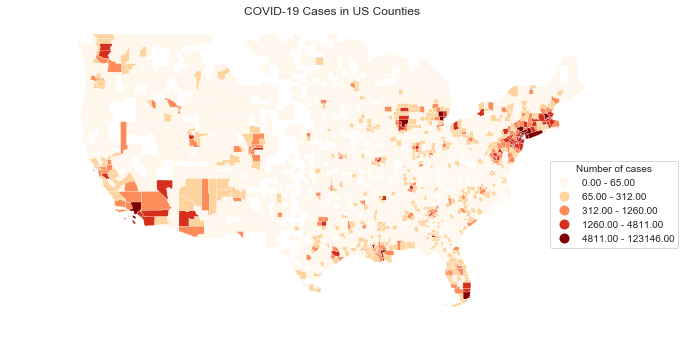

In [33]:
fig, ax = plt.subplots(1, figsize=(10, 10))
merged2.plot(column=variable,cmap='OrRd', scheme='jenks_caspall', legend=True,
            linewidth=0.2, ax=ax, edgecolor='1');

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.93, 0.35, 0.2, 0.2))
leg.set_title(legend_title)
# remove axis
ax.axis('off');
# add a title
ax.set_title(title, fontdict={'fontsize': '12', 'fontweight' : '8'});

In [34]:
#fig.savefig('covid_cases_in_US.png', dpi=300);